## Семинар 2 "Распознавание рукописных цифр"

ФИО: Каспарьянц Георгий Григорьевич

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.transforms import *
import numpy as np
from tqdm import tqdm
%matplotlib inline

In [2]:
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('.', train=False, transform=ToTensor())

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

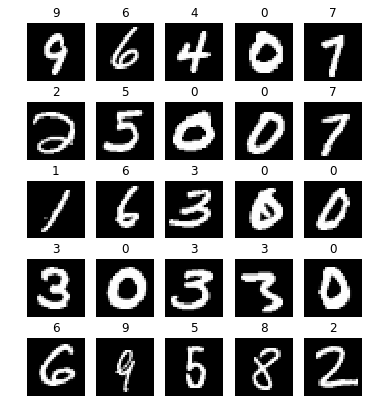

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [6]:
import numpy as np

class Linear:
    def __init__(self, input_size, output_size, mu=0, sigma=0.1):        
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        # input_size = (N, d)
        # output_size = (N, 1)
        self.name = 'Linear'
        self.input_size = input_size
        self.output_size = output_size
        self.mu = mu
        self.sigma = sigma
        self.w = self.sigma * np.random.randn(self.output_size, self.input_size) + self.mu
        self.b = self.sigma * np.random.randn(self.output_size) + self.mu
    
    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.array(X)
        out = np.transpose(
            self.w.dot(
                self.X.reshape([X.shape[0], self.input_size, 1])
            ),
            (1,0,2)
        ).reshape((X.shape[0],self.output_size)) + self.b
        return np.array(out) #[N, output_size]
    
    def backward(self, dLdy):
        '''
        dLdy [N, output_size]
        '''
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdw = np.sum(dLdy.reshape(dLdy.shape[0], -1, 1) * self.X.reshape(self.X.shape[0], 1, -1), axis=0)
        self.dLdb = np.sum(dLdy, axis=0)
        dLdx = []
        for i in range(dLdy.shape[0]):
            dLdx.append(np.matmul(dLdy[i].reshape(1, -1), self.w).reshape(-1))
        dLdx = np.array(dLdx)
        dLdx1 = dLdy.reshape(dLdy.shape[0], 1, -1).dot(self.w).reshape(dLdy.shape[0],-1)
        return np.array(dLdx)
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        #### YOUR CODE HERE
        assert(self.w.shape == self.dLdw.shape)
        
        self.w = self.w - learning_rate * self.dLdw
        self.b = self.b - learning_rate * self.dLdb
        
class Sigmoid:
    def __init__(self):
        self.name = 'Sigmoid'
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        self.X = np.array(X)
        self.sig = 1 / (1 + np.exp(-X))
        return self.sig
        
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        #return np.array([dLdy[i] * self.sig[i] * (1 - self.sig[i]) for i in range(dLdy.shape[0])])
        return dLdy * self.sig * (1 - self.sig)
    
    def step(self, learning_rate):
        pass
    
class ReLU:
    def __init__(self):
        self.name = 'ReLU'

    def forward(self, X):
        self.X = np.array(X)
        return np.maximum(X, 0)
    
    def backward(self, dLdy):
        return dLdy * (self.X > 0)
    
    def step(self, learning_rate):
        pass

class ELU:
    def __init__(self, a = 0.01):
        self.name = 'ReLU'
        self.a = a

    def forward(self, X):
        self.X = np.array(X)
        return X * (X >= 0) + self.a * (X < 0) * np.nan_to_num(np.log(np.exp(-X) - 1))
    
    def backward(self, dLdy):
        '''
        Без -0.1 было все плохо, градиент -> inf и loss подскакивает
        '''
        return dLdy * ((self.X >= -0.1) - (self.X < -0.1) * self.a * np.exp(-self.X) / (np.exp(-self.X) - 1))
    
    
    def step(self, learning_rate):
        pass
    
def softmax(X):
    a = np.exp(X)
    a /= np.sum(a, axis=1).reshape((-1,1))
    return a

class NLLLoss:
    def __init__(self):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        self.name = 'NLLLoss'
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        y is np.array of size (N,), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = np.array(X)
        self.y = np.array(y)
        a = softmax(self.X)
        self.a = np.array(a)
        l = np.log(a)
        return -np.trace(l[:, y])
        #return -np.sum([l[j, y[j]] for j in range(self.X.shape[0])])
        
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        N = self.X.shape[0]
        d = self.X.shape[1]
        p = self.a
        y = self.y
        
        dpdx = (np.diag(np.ones(p.shape[1])) - p.reshape((p.shape[0], 1, -1))) * p.reshape((p.shape[0], -1, 1))
        dLdx = []
        for i in range(N):
            dLdx.append([-dpdx[i, y[i], j0] / p[i, y[i]] for j0 in range(d)])
        return np.array(dLdx)
        
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.name = 'network'
        self.net = []
        for m in modules:
            self.net.append(m)
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        prev = np.array(X)
        for i in range(len(self.net)):
            prev = self.net[i].forward(prev)
        return prev
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        prev = dLdy
        for i in range(len(self.net)):
            prev = self.net[len(self.net) - i - 1].backward(prev)
        return prev
    
    def step(self, learning_rate):
        for l in self.net:
            l.step(learning_rate)
            

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

100%|██████████| 1875/1875 [01:33<00:00, 20.09it/s]


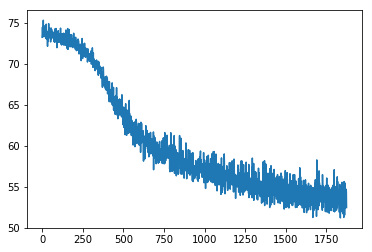

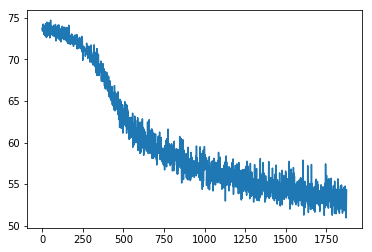

In [32]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

nn = NeuralNetwork([Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()])
loss = NLLLoss()
train_loss = []
test_loss = []
for X, y in tqdm(train_loader):
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pred = nn.forward(X)
    train_loss.append(loss.forward(pred, np.int32(y)))
    nn.backward(loss.backward())
    nn.step(0.01)
    for Xtest, ytest in test_loader:
        Xtest = Xtest.view(Xtest.size(0), -1)
        Xtest = Xtest.numpy()
        ytest = ytest.numpy()
        pred = nn.forward(Xtest)
        test_loss.append(loss.forward(pred, np.int32(ytest)))
        break
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [1]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

nn = NeuralNetwork([Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10), ReLU()])
loss = nn.NLLLoss()
train_loss = []
test_loss = []
for X, y in tqdm(train_loader):
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pred = nn.forward(X)
    train_loss.append(loss.forward(pred, np.int32(y)))
    nn.backward(loss.backward())
    nn.step(0.01)
    for Xtest, ytest in test_loader:
        Xtest = Xtest.view(Xtest.size(0), -1)
        Xtest = Xtest.numpy()
        ytest = ytest.numpy()
        pred = nn.forward(Xtest)
        test_loss.append(loss.forward(pred, np.int32(ytest)))
        break
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

NameError: name 'DataLoader' is not defined

100%|██████████| 1875/1875 [01:32<00:00, 20.33it/s]


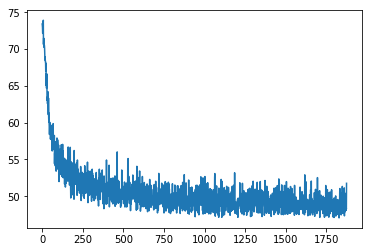

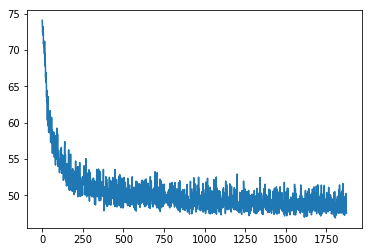

In [7]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

nn = NeuralNetwork([Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10), Sigmoid()])
loss = NLLLoss()
train_loss = []
test_loss = []
for X, y in tqdm(train_loader):
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pred = nn.forward(X)
    train_loss.append(loss.forward(pred, np.int32(y)))
    nn.backward(loss.backward())
    nn.step(0.01)
    for Xtest, ytest in test_loader:
        Xtest = Xtest.view(Xtest.size(0), -1)
        Xtest = Xtest.numpy()
        ytest = ytest.numpy()
        pred = nn.forward(Xtest)
        test_loss.append(loss.forward(pred, np.int32(ytest)))
        break
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

### Часть 3: Предобработка данных

Посчитайте на всей обучающей выборке матрицу ковариации и среднее. Нормализуйте данные по схеме: вычесть среднее, декоррелировать, нормировать дисперсию. Сравните графики обучения на одной и той же архитектуре с и без предобработки.

In [37]:
loader = DataLoader(train_dataset, batch_size=400, shuffle=True)

In [38]:
mat, m = 0, 0
i = 0
for X, y in loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    y = y.numpy()
    m += np.mean(X, axis=0)
    i += 1
m /= i
print(m.shape)
i = 0
for X, y in loader:
    X = X.view(X.size(0), -1)
    X = X.numpy()
    y = y.numpy()
    X -= m
    u, d, v = np.linalg.svd(np.cov(X))
    mat += np.matmul(np.matmul(u, np.diag(1 / np.sqrt(d))), v)
    i += 1
mat /= i

(784,)


100%|██████████| 150/150 [01:23<00:00,  1.76it/s]


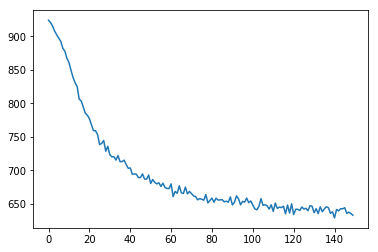

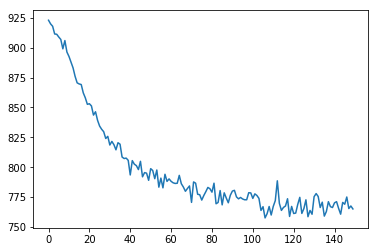

In [39]:
train_loader = DataLoader(train_dataset, batch_size=400, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=400, shuffle=True)

nn = NeuralNetwork([Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10), Sigmoid()])
loss = NLLLoss()
train_loss = []
test_loss = []
for X, y in tqdm(train_loader):
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    X = np.matmul(mat, X - m)
    pred = nn.forward(X)
    train_loss.append(loss.forward(pred, np.int32(y)))
    nn.backward(loss.backward())
    nn.step(0.01)
    for Xtest, ytest in test_loader:
        Xtest = Xtest.view(Xtest.size(0), -1)
        Xtest = Xtest.numpy()
        ytest = ytest.numpy()
        pred = nn.forward(Xtest)
        test_loss.append(loss.forward(pred, np.int32(ytest)))
        break
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
plt.plot(train_loss)
plt.show()
plt.plot(test_loss)
plt.show()

### Часть 4: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Из-за вычислительной трудоемкости я не смог декорелировать всю выборку, поэтому сделал частичную среднюю декорреляцию по всему датасету.
Как мы видим из двух графиков, предобработка данных уменьшила разброс градиентного спуска - тем самым улучшает сходимость